![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)

# Discover SWOT L3 Unsmoothed data, and compare with CMEMS L4 SLA and IFREMER SST data

## Tutorial Objectives
* Select Swot data with cycle/passes numbers, and download it through AVISO's FTP
* Select data intersecting a geographical area
* Download CMEMS map using ``copernicusmarine`` client, and plot Swot SLA with CMEMS SLA
* Download SST map using ``copernicusmarine`` client and plot Swot SLA with SST

Environment needed to run this notebook:
* ``ftplib``
* ``xarray``
* ``numpy``
* ``matplotlib``+``cartopy``+``cmocean``
* ``copernicusmarine``

## Import + code

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from getpass import getpass
import ftplib

import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
import cmocean

import copernicusmarine

In [3]:
def _download_file(ftp:str, filename:str, target_directory:str):
    print(f"Download file: {filename}")
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        
def _get_last_version_filename(filenames):
    versions = {int(f[-5:-3]): f for f in filenames}
    return versions[max(versions.keys())]

def _select_filename(filenames, only_last):
    if not only_last: return filenames
    return [_get_last_version_filename(filenames)]

def ftp_download_files(ftp_path, level, variant, cycle_numbers, half_orbits, output_dir, only_last=True):
    """ Download half orbits files from AVISO's FTP Server.
    Args:
        ftp_path
            path of the FTP fileset
        level
            L2 or L3
        variant
            Basic, Expert, WindWave or Unsmoothed
        cycle_numbers
            list of cycles numbers
        half_orbits
            list of passes numbers
        output_dir
            output directory
        only_last
            if True (Default), downloads only the last version of a file if several versions exist. 
            Downloads all versions otherwise.
    Returns:
        The list of local files.
    """
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    try:
        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")
            downloaded_files = []
            
            for cycle in cycle_numbers:
                cycle_str = '{:03d}'.format(cycle)
                cycle_dir = f'cycle_{cycle_str}'
                print(ftp_path+cycle_dir)
                ftp.cwd(cycle_dir)
    
                for half_orbit in half_orbits:
                    half_orbit_str = '{:03d}'.format(half_orbit)
                    pattern = f'SWOT_{level}_LR_SSH_{variant}_{cycle_str}_{half_orbit_str}'
                    filenames = []
                    try:
                        filenames = ftp.nlst(f'{pattern}_*')
                        # No version in L3 filenames
                        if level=="L3": only_last=False
                        filenames = _select_filename(filenames, only_last)
                    except Exception as e:
                        print(f"No pass {half_orbit}")
                        
                    local_files = [_download_file(ftp, f, output_dir) for f in filenames]
                    downloaded_files += local_files
                
                ftp.cwd('../')
                
            return downloaded_files
            
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")

def _normalized_ds(ds, lon_min, lon_max):
    lon = ds.longitude.values
    lon[lon < lon_min] += 360
    lon[lon > lon_max] -= 360
    ds.longitude.values = lon
    return ds
    
def _subset_ds(file, variables, lon_range, lat_range, output_dir):
    print(f"Subsetting dataset: {file}")
    swot_ds = xr.open_dataset(file)
    swot_ds = swot_ds[variables]
    swot_ds.load()

    ds = _normalized_ds(swot_ds.copy(), -180, 180)
    
    mask = (
        (ds.longitude <= lon_range[1])
        & (ds.longitude >= lon_range[0])
        & (ds.latitude <= lat_range[1])
        & (ds.latitude >= lat_range[0])
    ).compute()
    
    swot_ds_area = swot_ds.where(mask, drop=True)

    if swot_ds_area.sizes['num_lines'] == 0:
        print(f'Dataset {file} not matching geographical area.')
        return None

    for var in list(swot_ds_area.keys()):
        swot_ds_area[var].encoding = {'zlib':True, 'complevel':5}

    filename = "subset_"+file[10:]
    filepath = os.path.join(output_dir, filename)
    swot_ds_area.to_netcdf(filepath)
    print(f"Subset file created: {filename}")
        
    return filepath


def subset_files(filenames, variables, lon_range, lat_range, output_dir):
    """ Subset datasets with geographical area.
    Args:
        filenames
            the filenames of datasets to subset
        variables
            variables to select
        lon_range
            the longitude range
        lat_range
            the latitude range
        output_dir
            output directory
    Returns:
        The list of subsets files.
    """
    return [subset_file for subset_file in [_subset_ds(f, variables, lon_range, lat_range, output_dir) for f in filenames] if subset_file is not None]

In [4]:
def plot_datasets(datasets, variable, vminmax, title, extent=None):
    cb_args = dict(
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.3}
    )
    
    plot_kwargs = dict(
        x="longitude",
        y="latitude",
        cmap="Spectral_r",
        vmin=vminmax[0],
        vmax=vminmax[1],
    )

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
    if extent: ax.set_extent(extent)
    
    for ds in datasets:
        ds[variable].plot.pcolormesh(
            ax=ax,
            **plot_kwargs,
            **cb_args)
        cb_args=dict(add_colorbar=False)

    ax.set_title(title)
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True)
    gls.top_labels=False
    gls.right_labels=False

    return ax

## Parameters

Define **existing** output folder to save results

In [5]:
output_dir = "downloads"

Enter your AVISO+ credentials

In [6]:
username = input("Enter username:")

Enter username: aviso-swot@altimetry.fr


In [7]:
password = getpass(f"Enter password for {username}:")

Enter password for aviso-swot@altimetry.fr: ········


Define data parameters

In [8]:
# Basic, Expert, WindWave, Unsmoothed
dataset = "Unsmoothed"
# L2, L3
level = "L3"

Set the FTP files path

In [9]:
ftp_path = f'/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0_2/{dataset}/'

Define cycles and half_orbits numbers to download


<div class="alert alert-info"><b>Note</b><p>To look for Swot passes in a predefined geographical area and temporal period, use <a href="https://mybinder.org/v2/gh/CNES/search_swot/HEAD?labpath=notebook.ipynb">Search Swot</a> tool.</p></div>

In [10]:
cycle_numbers = [2, 3]
pass_numbers = [14, 169]

## Retrieve SWOT data

### Download files through FTP

In [11]:
downloaded_files = ftp_download_files(ftp_path, level, dataset, cycle_numbers, pass_numbers, output_dir, only_last=True)

Connection Established 220 192.168.10.119 FTP server ready
/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0_2/Unsmoothed/cycle_002
Download file: SWOT_L3_LR_SSH_Unsmoothed_002_014_20230811T132741_20230811T141908_v1.0.2.nc
Download file: SWOT_L3_LR_SSH_Unsmoothed_002_169_20230817T022159_20230817T031326_v1.0.2.nc
/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0_2/Unsmoothed/cycle_003
Download file: SWOT_L3_LR_SSH_Unsmoothed_003_014_20230901T101247_20230901T110413_v1.0.2.nc
Download file: SWOT_L3_LR_SSH_Unsmoothed_003_169_20230906T230705_20230906T235831_v1.0.2.nc


In [12]:
downloaded_files

['downloads/SWOT_L3_LR_SSH_Unsmoothed_002_014_20230811T132741_20230811T141908_v1.0.2.nc',
 'downloads/SWOT_L3_LR_SSH_Unsmoothed_002_169_20230817T022159_20230817T031326_v1.0.2.nc',
 'downloads/SWOT_L3_LR_SSH_Unsmoothed_003_014_20230901T101247_20230901T110413_v1.0.2.nc',
 'downloads/SWOT_L3_LR_SSH_Unsmoothed_003_169_20230906T230705_20230906T235831_v1.0.2.nc']

### Explore Swot data

In [13]:
ds = xr.open_dataset(downloaded_files[0])
[v for v in ds.variables]

['time',
 'calibration',
 'dac',
 'latitude',
 'longitude',
 'mdt',
 'mss',
 'ocean_tide',
 'quality_flag',
 'sigma0',
 'ssha',
 'ssha_noiseless',
 'ssha_unedited',
 'ugos',
 'ugosa',
 'vgos',
 'vgosa']

### Select data intersecting the geographical area

Define a geographical area

In [14]:
# English channel
lon_range = [-7, 4]
lat_range = [46, 52]

In [15]:
localbox = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]

Define variables to select

In [16]:
variables = ['time', 'ssha', 'ssha_noiseless', 'ssha_unedited', 'sigma0', 'quality_flag']

Subset files

In [17]:
subset_filenames = subset_files(downloaded_files, variables, lon_range, lat_range, output_dir)

Subsetting dataset: downloads/SWOT_L3_LR_SSH_Unsmoothed_002_014_20230811T132741_20230811T141908_v1.0.2.nc
Subset file created: subset_SWOT_L3_LR_SSH_Unsmoothed_002_014_20230811T132741_20230811T141908_v1.0.2.nc
Subsetting dataset: downloads/SWOT_L3_LR_SSH_Unsmoothed_002_169_20230817T022159_20230817T031326_v1.0.2.nc
Subset file created: subset_SWOT_L3_LR_SSH_Unsmoothed_002_169_20230817T022159_20230817T031326_v1.0.2.nc
Subsetting dataset: downloads/SWOT_L3_LR_SSH_Unsmoothed_003_014_20230901T101247_20230901T110413_v1.0.2.nc
Subset file created: subset_SWOT_L3_LR_SSH_Unsmoothed_003_014_20230901T101247_20230901T110413_v1.0.2.nc
Subsetting dataset: downloads/SWOT_L3_LR_SSH_Unsmoothed_003_169_20230906T230705_20230906T235831_v1.0.2.nc
Subset file created: subset_SWOT_L3_LR_SSH_Unsmoothed_003_169_20230906T230705_20230906T235831_v1.0.2.nc


In [18]:
subset_filenames

['downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_002_014_20230811T132741_20230811T141908_v1.0.2.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_002_169_20230817T022159_20230817T031326_v1.0.2.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_003_014_20230901T101247_20230901T110413_v1.0.2.nc',
 'downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_003_169_20230906T230705_20230906T235831_v1.0.2.nc']


<div class="alert alert-info"><b>Note</b><p>Size of a Swot L3 Unsmoothed half-orbit dataset: <b>400 Mb</b>
    
Size of the subset after geographical selection: <b>25 Mb</b></p></div>

In [19]:
subsets_cycle_02 = [xr.open_dataset(file) for file in subset_filenames[:2]]
subsets_cycle_03 = [xr.open_dataset(file) for file in subset_filenames[2:]]

### Visualise data

Let's plot SLA for each cycle

<GeoAxes: title={'center': 'Filtered SLA'}, xlabel='longitude (degrees East)\n[degrees_east]', ylabel='latitude (positive N, negative\nS) [degrees_north]'>

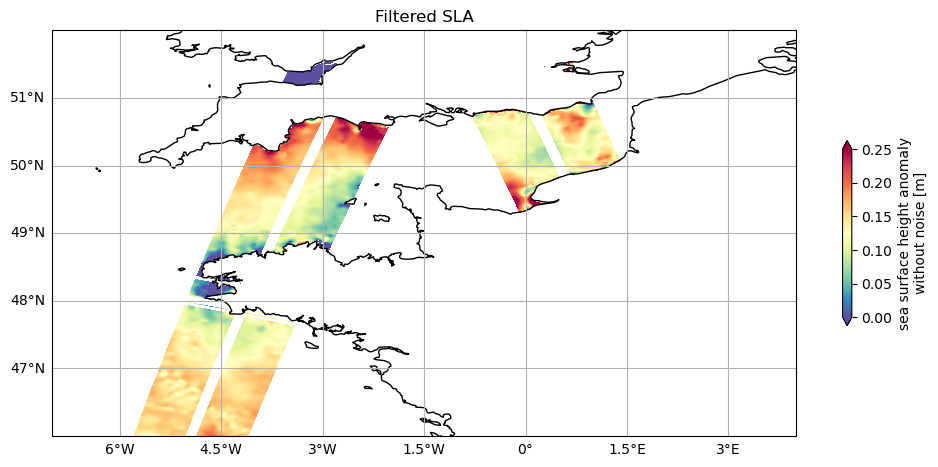

In [20]:
plot_datasets(subsets_cycle_02, 'ssha_noiseless', (0, 0.25), 'Filtered SLA', extent=localbox)

Let’s plot SWOT KaRIn Sigma 0 and the different SLA available

In [21]:
ds = subsets_cycle_02[1]

In [22]:
# Apply quality flag
ds["sigma0"] = ds.sigma0.where(ds.quality_flag==0)
# Apply log 10
ds["sigma0_log"] = 10*np.log10(ds["sigma0"])

In [23]:
localbox_zoom = [-5, -1.5, 46, 51]

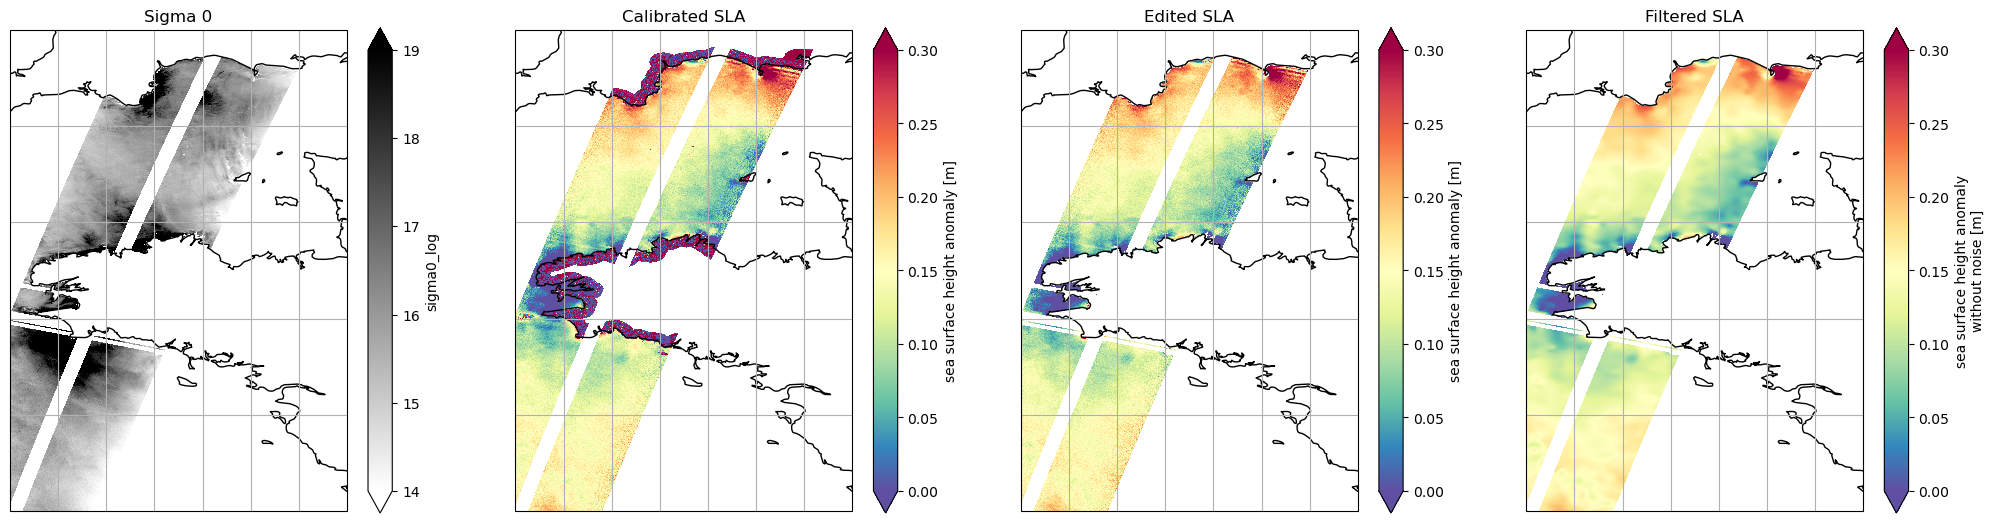

In [24]:
# set figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 21), subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r",
    vmin=0, 
    vmax=0.3,
    cbar_kwargs={"shrink": 0.3}
)
plot_kwargs2 = dict(
    x="longitude",
    y="latitude",
    cmap="gray_r",
    vmin=14,
    vmax=19,
    cbar_kwargs={"shrink": 0.3}
)

ds.sigma0_log.plot.pcolormesh(ax=ax1, **plot_kwargs2)
ax1.set_title("Sigma 0")

ds.ssha_unedited.plot.pcolormesh(ax=ax2, **plot_kwargs)
ax2.set_title("Calibrated SLA")

ds.ssha.plot.pcolormesh(ax=ax3, **plot_kwargs)
ax3.set_title("Edited SLA")
    
ds.ssha_noiseless.plot.pcolormesh(ax=ax4, **plot_kwargs)
ax4.set_title("Filtered SLA")

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_extent(localbox_zoom)
    ax.coastlines()
    ax.gridlines()

## Visualise SWOT SLA with L4 CMEMS SLA map

### Download L4 CMEMS SLA maps with ``copernicusmarine`` client

In [25]:
# passes 14, 169 cycle 02 of Swot
date_start = np.datetime64("2023-08-11T00:00:00")
date_end = np.datetime64("2023-08-17T00:00:00")

In [26]:
# Load xarray dataset
duacs_l4 = copernicusmarine.open_dataset(
  dataset_id = "cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D",
  start_datetime=date_start,
  end_datetime=date_end,
  minimum_longitude = lon_range[0],
  maximum_longitude = lon_range[1],
  minimum_latitude = lat_range[0],
  maximum_latitude = lat_range[1],
  variables = ['sla']
)

INFO - 2024-11-14T11:43:26Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-11-14T11:43:26Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-11-14T11:43:30Z - Service was not specified, the default one was selected: "arco-time-series"


In [27]:
duacs_l4

<xarray.Dataset> Size: 59kB
Dimensions:    (time: 7, latitude: 24, longitude: 44)
Coordinates:
  * latitude   (latitude) float32 96B 46.12 46.38 46.62 ... 51.38 51.62 51.88
  * longitude  (longitude) float32 176B -6.875 -6.625 -6.375 ... 3.625 3.875
  * time       (time) datetime64[ns] 56B 2023-08-11 2023-08-12 ... 2023-08-17
Data variables:
    sla        (time, latitude, longitude) float64 59kB ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-4 sea ...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-11-24T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-23T12:00:00Z
    title:                           NRT merged all satellites Global Ocean G...

### Visualise SWOT SLA with CMEMS SLA

In [28]:
localbox_zoom2 = [-5, -1.5, 46, 51]

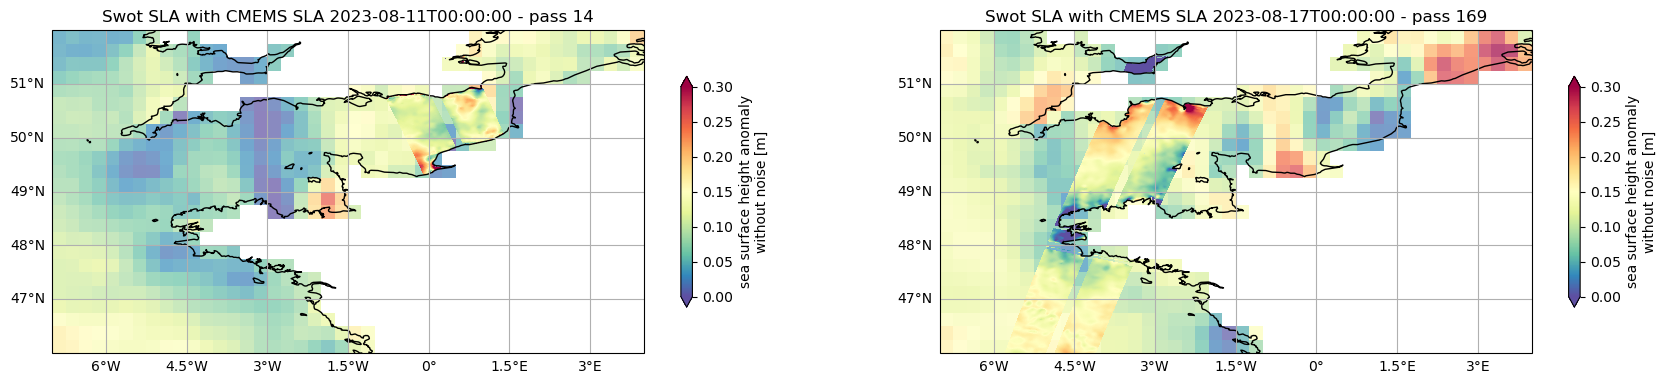

In [36]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r",
    vmin=0,
    vmax=0.3
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 15), subplot_kw=dict(projection=ccrs.PlateCarree()))

da = duacs_l4.sla.sel(time=date_start)
da.plot.pcolormesh(
    ax=ax1,
    alpha=0.7,
    add_colorbar=False,
    **plot_kwargs)
subsets_cycle_02[0]['ssha_noiseless'].plot.pcolormesh(
    ax=ax1,
    cbar_kwargs={"shrink": 0.2},
    **plot_kwargs)
ax1.set_title(f'Swot SLA with CMEMS SLA {date_start} - pass 14')
ax1.set_extent(localbox)

da = duacs_l4.sla.sel(time=date_end)
da.plot.pcolormesh(
    ax=ax2,
    alpha=0.7,
    add_colorbar=False,
    **plot_kwargs)
subsets_cycle_02[1]['ssha_noiseless'].plot.pcolormesh(
    ax=ax2,
    cbar_kwargs={"shrink": 0.2},
    **plot_kwargs)
ax2.set_title(f'Swot SLA with CMEMS SLA {date_end} - pass 169')
ax2.set_extent(localbox)

for ax in [ax1, ax2]:
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True)
    gls.top_labels=False
    gls.right_labels=False

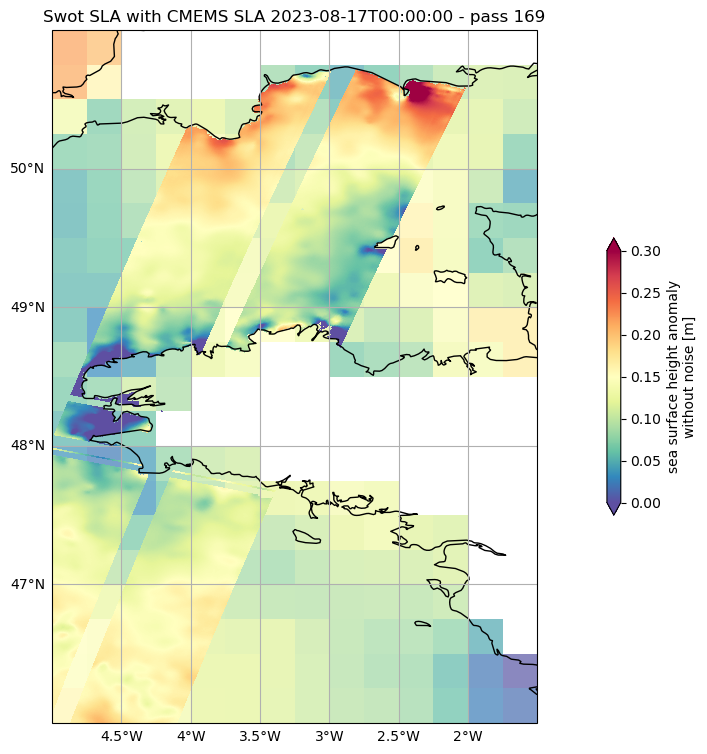

In [30]:
fig, ax = plt.subplots(figsize=(18, 9), subplot_kw=dict(projection=ccrs.PlateCarree()))

da.plot.pcolormesh(
    ax=ax,
    alpha=0.7,
    add_colorbar=False,
    **plot_kwargs)
subsets_cycle_02[1]['ssha_noiseless'].plot.pcolormesh(
    ax=ax,
    cbar_kwargs={"shrink": 0.4},
    **plot_kwargs)
ax.set_title(f'Swot SLA with CMEMS SLA {date_end} - pass 169')
ax.set_extent(localbox_zoom2)
ax.coastlines()
gls = ax.gridlines(draw_labels=True)
gls.top_labels=False
gls.right_labels=False

## Visualise SWOT SLA with IFREMER SST map

### Download SST maps with ``copernicusmarine`` client


In [31]:
# Load xarray dataset
sst = copernicusmarine.open_dataset(
  dataset_id = "IFREMER-GLOB-SST-L3-NRT-OBS_FULL_TIME_SERIE",
  start_datetime=date_start,
  end_datetime=date_end,
  minimum_longitude = lon_range[0],
  maximum_longitude = lon_range[1],
  minimum_latitude = lat_range[0],
  maximum_latitude = lat_range[1],
  variables = ['sea_surface_temperature']
)

INFO - 2024-11-14T11:43:41Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-11-14T11:43:41Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-11-14T11:43:43Z - Service was not specified, the default one was selected: "arco-time-series"


In [32]:
sst

<xarray.Dataset> Size: 370kB
Dimensions:                  (time: 7, latitude: 60, longitude: 110)
Coordinates:
  * latitude                 (latitude) float32 240B 46.05 46.15 ... 51.85 51.95
  * longitude                (longitude) float32 440B -6.95 -6.85 ... 3.85 3.95
  * time                     (time) datetime64[ns] 56B 2023-08-11 ... 2023-08-17
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float64 370kB ...
Attributes: (12/77)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:            Climate and Forecast (CF) 1.7, Attribute...
    acknowledgement:                 Please acknowledge the use of these data...
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    band:                            ['infrared', 'infrared', 'infrared', 'in...
    cdm_data_type:                   grid
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2023-12-10T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-12-09T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            96ef4d48-9801-11ee-a240-0cc47a3f7883

In [33]:
ds_sst = sst.sel(time=date_end)

### Visualise SWOT SLA with SST

Text(0.5, 1.0, 'Swot SLA with SST')

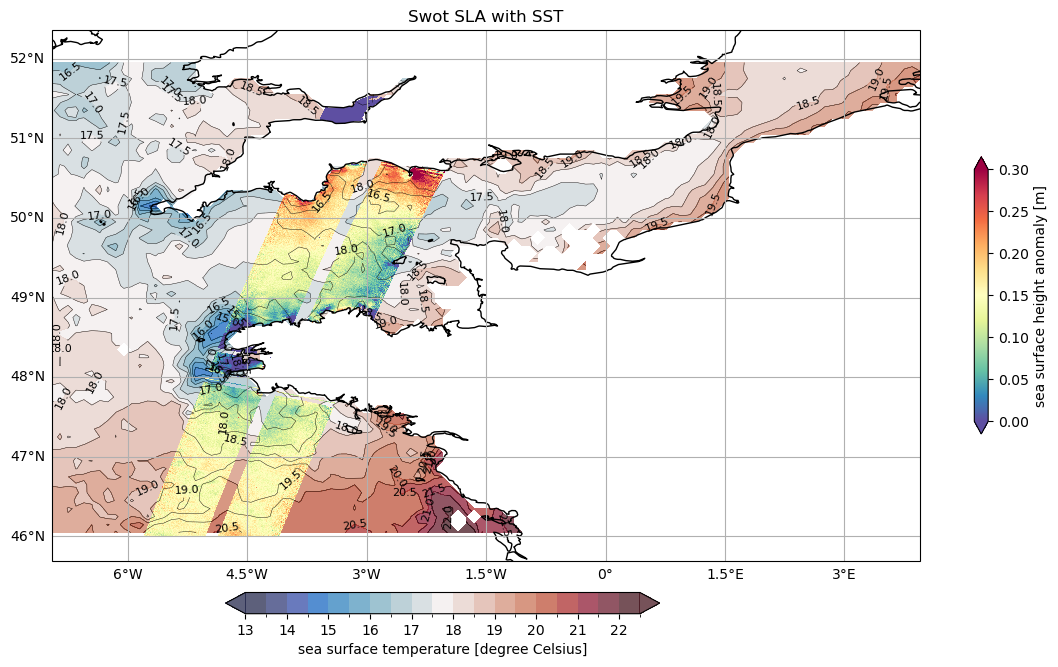

In [34]:
fig, ax = plt.subplots(figsize=(14, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r"
) 

cb_args = dict(
    add_colorbar=True,
    cbar_kwargs={"shrink": 0.3}
)

cmap_sst = cmocean.cm.balance
levs_sst = np.arange(13,23,step=0.5)
norm_sst = mplcm.colors.BoundaryNorm(levs_sst,cmap_sst.N)

contourf = ax.contourf(ds_sst.longitude, 
                      ds_sst.latitude, 
                      ds_sst.sea_surface_temperature-273.15, 
                      levs_sst,
                      cmap=cmap_sst, 
                      norm=norm_sst,
                      alpha=0.7,
                      extend='both')

contour = ax.contour(ds_sst.longitude, 
                      ds_sst.latitude, 
                      ds_sst.sea_surface_temperature-273.15, 
                      levels=levs_sst,
                      colors="black",
                      linewidths=0.3)

ax.clabel(contour, inline=1, fontsize=8)

cax = ax.inset_axes([0.2, -0.1, 0.5, 0.04])

cb_sst = plt.colorbar(contourf, cax=cax, orientation='horizontal', pad=0.005, shrink=0.5)
cb_sst.set_label('sea surface temperature [degree Celsius]')
cb_sst.ax.tick_params(labelsize=10)

subsets_cycle_02[1]['ssha'].plot.pcolormesh(
    ax=ax,
    vmin=0,
    vmax=0.3,
    **plot_kwargs,
    **cb_args)

ax.coastlines()
gls = ax.gridlines(draw_labels=True)
gls.top_labels=False
gls.right_labels=False
ax.set_title('Swot SLA with SST')

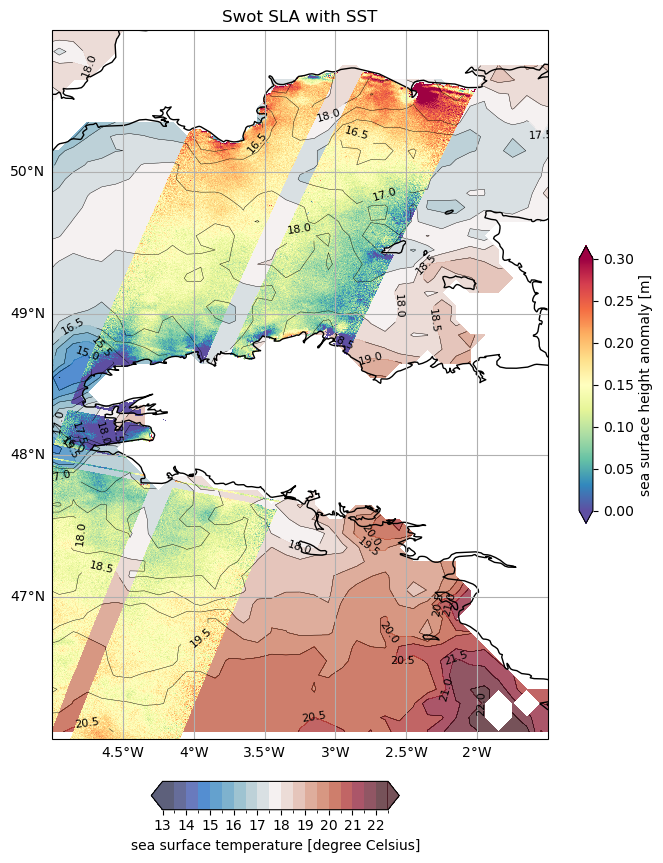

In [35]:
fig, ax = plt.subplots(figsize=(14, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

contourf = ax.contourf(ds_sst.longitude, 
                      ds_sst.latitude, 
                      ds_sst.sea_surface_temperature-273.15, 
                      levs_sst,
                      cmap=cmap_sst, 
                      norm=norm_sst,
                      alpha=0.7,
                      extend='both')

contour = ax.contour(ds_sst.longitude, 
                      ds_sst.latitude, 
                      ds_sst.sea_surface_temperature-273.15, 
                      levels=levs_sst,
                      colors="black",
                      linewidths=0.3)

ax.clabel(contour, inline=1, fontsize=8)

cax = ax.inset_axes([0.2, -0.1, 0.5, 0.04])

cb_sst = plt.colorbar(contourf, cax=cax, orientation='horizontal', pad=0.005, shrink=0.5)
cb_sst.set_label('sea surface temperature [degree Celsius]')
cb_sst.ax.tick_params(labelsize=10)

subsets_cycle_02[1]['ssha'].plot.pcolormesh(
    ax=ax,
    vmin=0,
    vmax=0.3,
    **plot_kwargs,
    **cb_args)

ax.coastlines()
gls = ax.gridlines(draw_labels=True)
gls.top_labels=False
gls.right_labels=False
ax.set_title('Swot SLA with SST')
fig.set_figwidth(8)
ax.set_extent(localbox_zoom2)